In [1]:
#!pip install fastai wwf -q --upgrade

In [2]:
#!pip3 install torch

In [3]:
#!pip3 install iprogress

In [4]:
#!jupyter nbextension enable --py widgetsnbextension

In [5]:
#!pip install pillow

In [6]:
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])

from fastai.vision.all import *

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import *

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import *

import torch
import torch.nn.functional as F

from PIL import Image, ImageOps
import os, sys

from pathlib import Path

In [7]:
path = "/home/ankitk/.fastai/data/camvid/images"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((256,256), Image.ANTIALIAS)
#             imResize = ImageOps.grayscale(imResize)
            imResize.save(f +'.png','PNG', quality=100)

resize()


path = "/home/ankitk/.fastai/data/camvid/labels"
dirs = os.listdir( path )

resize()

In [8]:
path = Path('/home/ankitk/.fastai/data/camvid')

In [9]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [10]:
valid_fnames[:5]

['10_bachamollaharshavardhanreddy.png',
 '10_kanugovimahidhar.png',
 '10_rabbyshahariar.png',
 '11_bachamollaharshavardhanreddy.png',
 '11_rabbyshahariar.png']

In [11]:
path_im = path/'images'
path_lbl = path/'labels'

In [12]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

<AxesSubplot:>

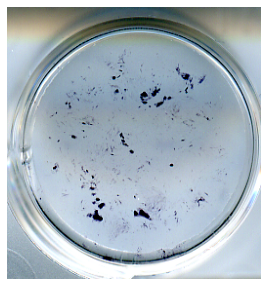

In [13]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [14]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

<AxesSubplot:>

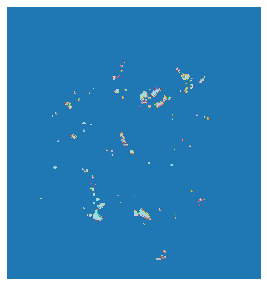

In [15]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [16]:
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [17]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Background', 'Cell'], dtype='<U10')

In [18]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [19]:
sz = msk.shape; sz

(279, 260)

In [20]:
half = tuple(int(x/2) for x in sz); half

(139, 130)

In [21]:
binaryseg = DataBlock(blocks=(ImageBlock(PILImageBW), MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   item_tfms=[Resize(256)],
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [22]:
dls = binaryseg.dataloaders(path/'images', bs=10)

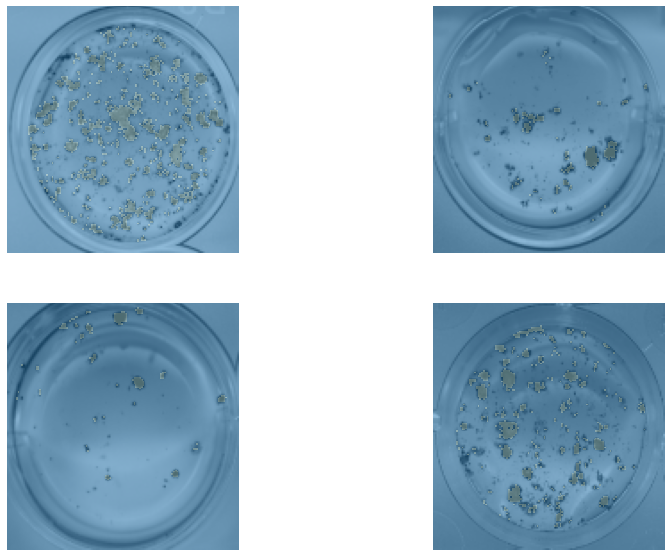

In [23]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [24]:
dls.vocab = codes

In [25]:
name2id = {v:k for k,v in enumerate(codes)}

In [26]:
name2id

{'Background': 0, 'Cell': 1}

In [27]:
void_code = name2id['Background']

In [28]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [29]:
opt = ranger

In [30]:
learn = unet_learner(dls, resnet34, metrics=error_rate, self_attention=True, act_cls=Mish, opt_func=opt, n_out=1)
#learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [31]:
learn.summary()

DynamicUnet (Input shape: 10 x 3 x 139 x 130)
Layer (type)         Output Shape         Param #    Trainable 
                     10 x 64 x 70 x 65   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     10 x 64 x 35 x 33   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

In [32]:
learn.lr_find()

RuntimeError: cuda runtime error (710) : device-side assert triggered at /pytorch/aten/src/THC/generic/THCTensorMath.cu:29

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_flat_cos(10, slice(lr))

In [ ]:
learn.save('stage-1')
learn.load('stage-1');

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(12, lrs)

In [ ]:
learn.save('model_1')

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

In [ ]:
dl = learn.dls.test_dl(fnames[:5])

In [ ]:
dl.show_batch()

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

In [ ]:
len(codes)

In [ ]:
pred_1 = preds[0][0]

In [ ]:
pred_1.shape

In [ ]:
pred_arx = pred_1.argmax(dim=0)

In [ ]:
plt.imshow(pred_arx)

In [ ]:
pred_arx = pred_arx.numpy()

In [ ]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)

In [ ]:
im

In [ ]:
im.save('test.png')

In [ ]:
for i, pred in enumerate(preds[0]):
    pred_arg = pred.argmax(dim=0).numpy()
    rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(f'Image_{i}.png')

In [ ]:
torch.save(preds[0][0], 'Image_1.pt')

In [ ]:
pred_1 = torch.load('Image_1.pt')

In [ ]:
plt.imshow(pred_1.argmax(dim=0))